# README

This notebook allows conversion of GPS Data from a DJI Mini 3 using .csv flight logs downloaded from AirData.

# I. General

### Imports

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid
import numpy as np
import argparse
import os
import glob

from datetime import datetime
from sklearn import metrics, svm, tree
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from geopy import distance

import math

In [12]:
# Command line arguments

parser = argparse.ArgumentParser(
                    prog='GPS Conversion',
                    description='Coverts GPS Data to a format resembling processed RADAR data. Files are pulled from data/raw/gps or the provided directory.')

parser.add_argument('-l', '--trackLength', type=int, default=20, help="Tracks will be split into pieces of size trackLength.")
parser.add_argument('-n', '--noise', type=float, default=0.2, help="Random noise magnitude")
parser.add_argument('-scaleLow', '--scalingLowerBound', type=int, default=1.5, help="Lower bound of the multiplier for scaling of input data.")
parser.add_argument('-scaleHigh', '--scalingUpperBound', type=int, default=2, help="Upper bound of the multiplier for scaling of input data.")
parser.add_argument('-r', '--reverseTracks', type=bool, default=False, help="Adds reversed versions of each track to the output.")
parser.add_argument('-sampleLow', '--samplingLowerBound', type=int, default=2, help="Lower bound for sampling rate.")
parser.add_argument('-sampleHigh', '--samplingUpperBound', type=int, default=2, help="Upper bound for sampling rate.")
parser.add_argument('-c', '--cycles', type=int, default=2, help="Determines number of variations used for scaling/sampling")

parser.add_argument('-in', "--inPath", type=str, default='../data/raw/gps/unprocessed', nargs='+', help="Processed all files in this directory")
parser.add_argument('-out', "--outName", type=str, default='processedGPSData', nargs='+', help="Output filename")

parser.add_argument('-f', '--files', help='-f is buggy with Jupyter. Ignore this')

args = parser.parse_args()

 # Parse paths
files = set()
files |= set(glob.glob(args.inPath + '/*' + '.csv'))

### Constants

In [13]:
NI_GPS = ['datetime(utc)', 'height_above_takeoff(feet)', 
          'height_above_ground_at_drone_location(feet)', 
          'ground_elevation_at_drone_location(feet)', 
          'height_sonar(feet)', 'distance(feet)', 'mileage(feet)',
          'satellites', 'gpslevel', 'voltage(v)', 'max_altitude(feet)',
          'max_ascent(feet)', 'max_speed(mph)', 'max_distance(feet)',
          ' xSpeed(mph)', ' ySpeed(mph)', ' zSpeed(mph)', ' compass_heading(degrees)', 
          ' pitch(degrees)', ' roll(degrees)', 'isPhoto', 'isVideo', 'rc_elevator',
          'rc_aileron', 'rc_throttle', 'rc_rudder', 'rc_elevator(percent)', 'rc_aileron(percent)',
          'rc_throttle(percent)', 'rc_rudder(percent)', 'gimbal_heading(degrees)',
          'gimbal_pitch(degrees)', 'gimbal_roll(degrees)', 'battery_percent',
          'voltageCell1', 'voltageCell2', 'voltageCell3', 'voltageCell4',
          'voltageCell5', 'voltageCell6', 'current(A)', 'battery_temperature(f)',
          'altitude(feet)', 'ascent(feet)', 'flycStateRaw', 'flycState', 'message']

GPS_MAP = {
    'time(millisecond)': 'UpdateTime',
    'latitude': 'Position_lat_',
    'longitude': 'Position_lon_',
    'altitude_above_seaLevel(feet)': 'Position_altMSL_',
    'speed(mph)': 'Speed',
}


### Helper Functions

In [14]:

def findRange(lat1, lon1, alt1, lat2, lon2, alt2):
    dist2d = distance.distance([lat1, lon1], [lat2, lon2]).m
    dist3d = np.sqrt(dist2d**2 + (alt2 - alt1)**2)
    return np.abs(dist3d)

def findBearing(lat1, lon1, lat2, lon2):
    brng = np.arctan((lon2-lon1)/(lat2-lat1)) * 360 /2 / math.pi
    if brng < 0: brng+= 360
    return brng

def findElevation(lat1, lon1, alt1, lat2, lon2, alt2):
    dist2d = distance.distance([lat1, lon1], [lat2, lon2]).m
    elevationAngle = np.arctan((alt2 - alt1)/dist2d) * 360 / 2 / math.pi
    return elevationAngle

def findRadialVelocity(vecX1, vecY1, vecX2, vecY2):
    diffX = vecX2-vecX1
    diffY = vecY2-vecY1
    return np.sqrt(diffX**2 + diffY**2)

### Load and process GPS data

In [15]:
# load gps data
gpsTracks = []
finalTracks = []
gpsData = files

generativeCycles = args.cycles
scalingRange = [args.scalingLowerBound, args.scalingUpperBound]
samplingRange = [args.samplingLowerBound, args.samplingUpperBound]

#Loops for number of generativeCycles
for rep in range(generativeCycles):
    #Determine sampling/scaling values
    sampling = samplingRange[0] + (samplingRange[1]-samplingRange[0])/(generativeCycles-1)*rep
    scale = scalingRange[0] + (scalingRange[1]-scalingRange[0])/(generativeCycles-1)*rep

    print("Beginning cycle " + str(rep+1) + ".")
    print("Current scaling: " + str(scale))
    print("Current sampling rate: " + str(sampling))

    #picks every (samplingRate)th track, leaving out the first 20s of each track
    for data in gpsData:
        gpsTracks.append(pd.read_csv(data).iloc[200:-200:int(sampling), :])

    #Loops through each file (each file is one track)
    for track in gpsTracks:
        data = track.copy()

        track_IDs = [None] * len(data)
        ranges = [None] * len(data)
        bearings = [None] * len(data)
        elevations = [None] * len(data)
        radialVels = [None] * len(data)

        latNew = [None] * len(data)
        longNew = [None] * len(data)
        altNew = [None] * len(data)

        radarLat = np.random.uniform(-0.04, 0.04) + data['latitude'].iat[0]
        radarLon = np.random.uniform(-0.04, 0.04) + data['longitude'].iat[0]
        radarAlt = np.random.uniform(-200, 200) + data['altitude_above_seaLevel(feet)'].iat[0]

        lastDiffX = 0
        lastDiffY = 0

        #Speed/Distance scaling
        latNew[0] = data['latitude'].iat[0]
        longNew[0] = data['longitude'].iat[0]
        altNew[0] = data['altitude_above_seaLevel(feet)'].iat[0]

        #Used to match lat/lon with scaled speed (currently does not account for fast sampling)
        for i in range(len(data)-1):
            latNew[i+1] = scale*(data['latitude'].iat[i+1]-data['latitude'].iat[i]) + latNew[i]
            longNew[i+1] = scale*(data['longitude'].iat[i+1]-data['longitude'].iat[i]) + longNew[i]
            altNew[i+1] = scale*(data['altitude_above_seaLevel(feet)'].iat[i+1]-data['altitude_above_seaLevel(feet)'].iat[i]) + altNew[i]
            #Random noise
            data['speed(mph)'].iat[i] = max(data['speed(mph)'].iat[i] + np.random.normal(0, args.noise), 0)
            #data['speed(mph)'].iat[i] = (10/sampling) * distance.geodesic([data['longitude'].iat[i+1], data['latitude'].iat[i+1]], [data['longitude'].iat[i], data['latitude'].iat[i]]).meters

        data['latitude'] = latNew
        data['longitude'] = longNew
        data['altitude_above_seaLevel(feet)'] = altNew
        data['speed(mph)'] *= scale#*sampling/10

        #Split every 20th track
        for i in range(len(data)):

            #Splitting tracks into multiple UUIDs
            if i % 20 == 0:
                if(i+20 < len(data)):
                    id = str(uuid.uuid1())

            #Calculation of range, bearing, elevation angle
            track_IDs[i] = id
            ranges[i] = findRange(data['latitude'].iat[i], data['longitude'].iat[i], data['altitude_above_seaLevel(feet)'].iat[i],
                                radarLat, radarLon, radarAlt)
            bearings[i] = findBearing(data['latitude'].iat[i], data['longitude'].iat[i],
                                radarLat, radarLon)
            elevations[i] = findElevation(data['latitude'].iat[i], data['longitude'].iat[i], data['altitude_above_seaLevel(feet)'].iat[i],
                                radarLat, radarLon, radarAlt)
            
            currentDiffX = distance.distance([data['latitude'].iat[i], 0], [radarLat, 0]).m
            currentDiffY = distance.distance([data['longitude'].iat[i], 0], [radarLon, 0]).m

            radialVels[i] = findRadialVelocity(lastDiffX, lastDiffY, currentDiffX, currentDiffY)

            lastDiffX = currentDiffX
            lastDiffY = currentDiffY

            # speed unit conversion
            data['speed(mph)'].iat[i]*=0.44704
            #data['speed(mph)'].iat[i] = max(data['speed(mph)'].iat[i] + np.random.normal(0, args.noise), 0)

        data['UUID'] = track_IDs
        data['Range'] = ranges
        data['AZ'] = bearings
        data['EL'] = elevations
        
        # Wasn't letting me drop first row during iteration idk why
        radialVels[0] = radialVels[1]
        data['RadialVelocity'] = radialVels

        finalTracks.append(data)
        
        #Add reversed track
        if(args.reverseTracks):
            data_r = data.copy()
            data_r['speed(mph)'] = data['speed(mph)'].shift(1)
            data_r['time(millisecond)'] = data['time(millisecond)'].values[::-1]

            finalTracks.append(data_r.iloc[1:])
            
    gpsTracks = []

df_gps = pd.concat(finalTracks, ignore_index=True)
df_gps["Combat ID"] = "HOSTILE"
df_gps = df_gps.sort_values(by='time(millisecond)', ascending=True)
df_gps.name = 'gpsData.csv'

# drop unimportant columns from gps data
df_gps = df_gps.drop(columns=NI_GPS)
    
# rename all of the gps columns to match ecco
df_gps = df_gps.rename(columns=GPS_MAP, errors='raise')

Beginning cycle 1.
Current scaling: 1.5
Current sampling rate: 2.0
Beginning cycle 2.
Current scaling: 2.0
Current sampling rate: 2.0


### Save new CSV

In [16]:
df_gps.to_csv('..\data/raw/gps/processed/' + args.outName + ".csv", index=False)
print("Saved file to ../data/raw/gps/processed/" + args.outName + ". File contains " + str(len(df_gps)) + " updates.")

Saved file to ../data/raw/gps/processed/processedGPSData. File contains 25966 updates.


### Plot Data

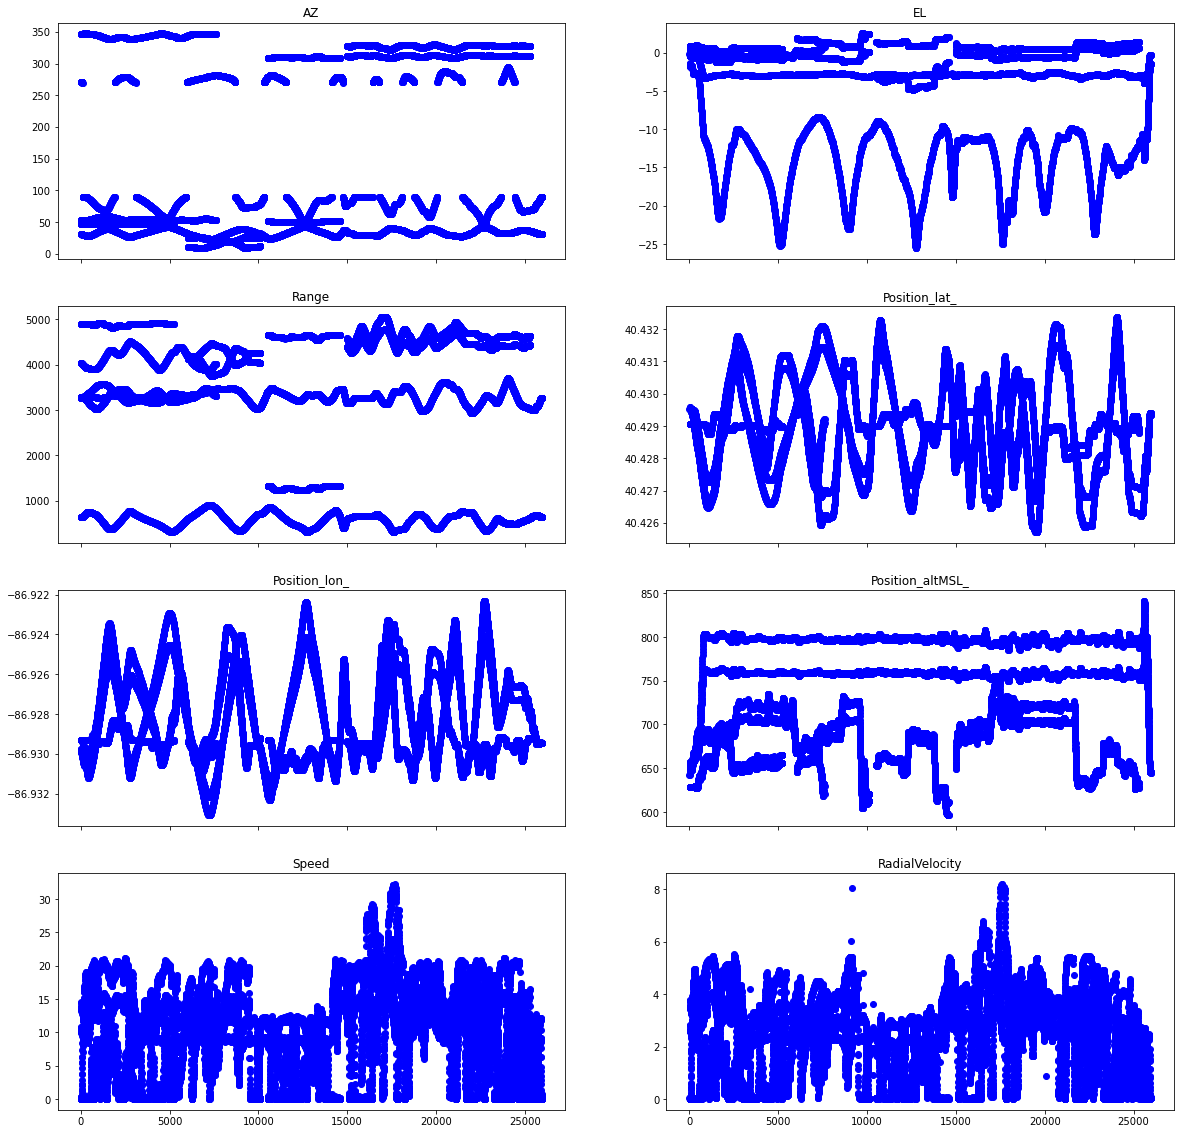

In [17]:
graph = ['AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity']

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20,20), sharex=True)

for i, ax in enumerate(axes.flatten()):
    plot = ax.scatter(np.arange(len(df_gps['RadialVelocity'])), df_gps[graph[i]], c='blue')
    ax.set_title(graph[i])